In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

In [4]:
BASE_DIR = '/content/drive/MyDrive/FLICKR30K'
WORKING_DIR = '/content/drive/MyDrive/FLICKR30K'

In [5]:
# Load InceptionV3 model
model = InceptionV3(include_top=False, pooling='avg')
print(model.summary())
print(plot_model(model, show_shapes=True))

87910968/87910968 [==============================] - 0s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [ ]:
import os
from tqdm import tqdm
import pickle
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

directory = os.path.join(BASE_DIR, 'Images')

# Load the InceptionV3 model
model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')

# Dictionary to store features
features = {}

# Ensure the image directory exists
if not os.path.exists(directory):
    raise FileNotFoundError(f"Directory {directory} does not exist.")

# Process each image in the directory
for img_name in tqdm(os.listdir(directory)):
    try:
        img_path = os.path.join(directory, img_name)
        image = load_img(img_path, target_size=(299, 299))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = os.path.splitext(img_name)[0]
        features[image_id] = feature
    except Exception as e:
        print(f"Error processing {img_name}: {e}")
        continue

# Store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features_inception.pkl'), 'wb'))

In [6]:
# Load features
with open(os.path.join(WORKING_DIR, 'features_inception.pkl'), 'rb') as f:
    features = pickle.load(f)

with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
# Create mapping of image to captions
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

clean(mapping)

  0%|          | 0/158916 [00:00<?, ?it/s]

In [8]:
import os
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

# Assuming 'mapping' is a dictionary where keys are identifiers and values are lists of captions
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

# Initialize tokenizer and fit on all captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

# Save tokenizer using pickle
tokenizer_path = os.path.join(WORKING_DIR, 'tokenizer.pkl')  # Update WORKING_DIR as needed
with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Optionally, calculate vocab size
vocab_size = len(tokenizer.word_index) + 1  # +1 for the reserved 0 index

In [9]:
#load tokenizer
tokenizer = pickle.load(open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'rb'))
max_length = max(len(caption.split()) for caption in all_captions)
max_length

75

In [11]:
#train-test split
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

In [10]:
#data generator
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [12]:
#model architecture
inputs1 = Input(shape=(2048,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
print(plot_model(model, show_shapes=True))
print(model.summary())

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
None
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None, 75)]                 0         []                            
                                                                                                  
 image (InputLayer)          [(None, 2048)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 75, 256)              4688384   ['text[0][0]']                
                                                                                                  
 dropout (Dropout)           (None, 204

In [ ]:
#train model
epochs = 12
batch_size = 128
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

model.save(WORKING_DIR + '/model_inception.h5')

In [13]:
from keras.models import load_model
model = load_model(WORKING_DIR + '/model_inception.h5')

In [14]:
#caption prediction
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [15]:
#check validation
from nltk.translate.bleu_score import corpus_bleu
from tqdm.notebook import tqdm
actual, predicted = list(), list()
for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

KeyboardInterrupt: 

In [16]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

---------------------Actual---------------------
startseq single person squated down at the edge of pier overlooking lake endseq
startseq person with red backpack squatting at the end of dock endseq
startseq person is squatting at the end of pier near lake endseq
startseq person crouches at the end of dock on lake endseq
startseq am squatting on dock looking into lake ." endseq
--------------------Predicted--------------------
startseq man in blue shirt and blue jeans is riding on the edge of the river endseq


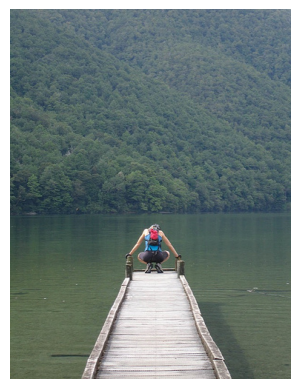

---------------------Actual---------------------
startseq five individuals are standing on lawn talking and preparing to play their varied stringed instruments ." endseq
startseq five individuals standing on grass next to brick building holding their own string instrument ." endseq
startseq five individuals holding instruments and practicing music together next to building endseq
startseq four male musicians and one female musician are playing instruments outside house endseq
startseq five musicians stand in circle on lawn endseq
--------------------Predicted--------------------
startseq two women are playing in the grass endseq


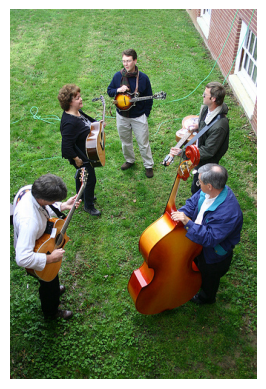

---------------------Actual---------------------
startseq an indian looking girl in green jacket with california written on it is pulling back on slingshot endseq
startseq native girl in green shirt readies slingshot endseq
startseq native girl showing slingshot to the camera endseq
startseq young girl wearing green is playing outside endseq
startseq young woman smiling holding slingshot endseq
--------------------Predicted--------------------
startseq young boy in blue shirt and blue jeans is walking in the woods endseq


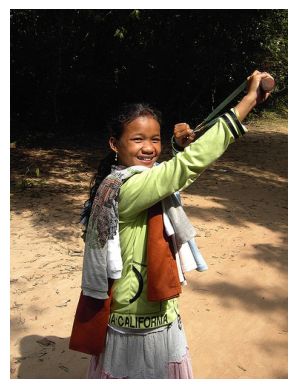

In [17]:
#testing for dataset
generate_caption("2182050469.jpg")
generate_caption("2173115233.jpg")
generate_caption("2185255150.jpg")

In [18]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from PIL import Image

# Load the InceptionV3 model for feature extraction
def load_feature_extractor():
    base_model = InceptionV3(weights='imagenet')
    model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)
    return model

# Extract features from an image
def extract_features(image_path, feature_extractor):
    image = load_img(image_path, target_size=(299, 299))  # InceptionV3 target size
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = feature_extractor.predict(image, verbose=0)
    return feature

# Generate caption for an image
def generate_caption_for_external_image(image_path, feature_extractor, captioning_model, tokenizer, max_length):
    # Extract features from the image
    feature = extract_features(image_path, feature_extractor)

    # Initialize the text input sequence (start token)
    in_text = 'startseq'

    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)  # pad the sequence
        yhat = captioning_model.predict([feature, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word[yhat]
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break

    caption = in_text.split()[1:-1]
    caption = ' '.join(caption)

    image = Image.open(image_path)
    print('--------------------Predicted--------------------')
    print(caption)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

--------------------Predicted--------------------
young boy is playing with balloon balloons


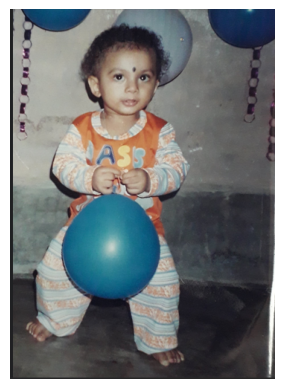

In [28]:
# Example usage:
# Initialize the models and tokenizer
feature_extractor = load_feature_extractor()
captioning_model = load_model(WORKING_DIR + '/model_inception.h5')
tokenizer = pickle.load(open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'rb'))
max_length = 75  # Example maximum sequence length

# Path to the image you want to caption
image_path = '/content/drive/MyDrive/try/Sum.png'
# Generate the caption
generate_caption_for_external_image(image_path, feature_extractor, captioning_model, tokenizer, max_length)